In [1]:
import pandas
import os
import pixiedust

Pixiedust database opened successfully


# Look at our data

In [2]:
demographics = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_demographic.csv', delimiter="\t")
display(demographics)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,STD_STATUS,STD_GENDER,STD_LANGUAGE,STD_RELIGION,BIRTH_YEAR,DEATH_YEAR,IS_DECEASED,POSTAL_CODE_3,STD_ETHNICITY,STD_INSURANCE_TYPE,STD_RACE
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:05:23,1,1,eng,nan,1923,nan,False,631.0,non-hispanic,MEDICARE,101
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:23,1,1,eng,nan,1943,nan,False,157.0,declined,MEDICARE,101
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:05:23,1,2,eng,nan,1936,nan,False,170.0,declined,MEDICARE,101
00021CA6FF03E670,BILLING,00021CA6FF03E670,2016-03-03 19:05:23,1,1,eng,nan,1941,nan,False,800.0,non-hispanic,MEDICARE,615
00024B3D2352D2D0,BILLING,00024B3D2352D2D0,2016-03-03 19:05:23,1,1,eng,nan,1936,nan,False,544.0,non-hispanic,MEDICARE,101
0002DAE1C81CC70D,BILLING,0002DAE1C81CC70D,2016-03-03 19:05:23,1,1,eng,nan,1943,nan,False,110.0,non-hispanic,MEDICARE,203
0002F28CE057345B,BILLING,0002F28CE057345B,2016-03-03 19:05:23,1,1,eng,nan,1922,nan,False,170.0,non-hispanic,MEDICARE,101
000308435E3E5B76,BILLING,000308435E3E5B76,2016-03-03 19:05:23,1,1,eng,nan,1935,nan,False,556.0,hispanic,MEDICARE,101
000345A39D4157C9,BILLING,000345A39D4157C9,2016-03-03 19:05:23,1,2,eng,nan,1976,nan,False,481.0,non-hispanic,MEDICARE,101
00036A21B65B0206,BILLING,00036A21B65B0206,2016-03-03 19:05:23,1,2,eng,nan,1938,nan,False,350.0,non-hispanic,MEDICARE,203


In [3]:
histories = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_medical_history.csv', delimiter="\t")
display(histories)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,ENCOUNTER_RECORD_ID_HASH,ENCOUNTER_JOIN_ID,ICD_CODE,ICD_VERSION,STD_MEDICAL_HISTORY_DATE,CONTACT_DATE,SNOMED_IDS
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:26:33,542192281063886,542192281063886,V58.83,ICD9,2008-09-04 00:00:00,2008-09-04 00:00:00,"275917000,166938002,166943009"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,272.4,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,"55822004,13644009,238040008,234413005,3744001,238037008,238080004,238088006,238089003,299465007,445261005,426161002,402727002,402725005,402785008,402474007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,318.2,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,31216003
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,V58.69,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,"417284009,408536007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,427.31,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,49436004
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542282281644416,542282281644416,959.4,ICD9,2009-06-23 00:00:00,2009-06-23 00:00:00,"125599006,210574006,210575007,210585008,210588005,262971000,263264005,268117002,441886002,283809003,298080001,283568001,283567006,283566002,283202002,283160004,441885003,298081002,298082009,427914009,439052006,283161000"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542282281644416,542282281644416,401.9,ICD9,2009-06-23 00:00:00,2009-06-23 00:00:00,59621000
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:26:33,542642281250669,542642281250669,564.09,ICD9,2009-10-11 00:00:00,2009-10-11 00:00:00,"236069009,163890000,430097009,432994008,31499008,197120000,21782001"
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:26:33,542642281250669,542642281250669,789.43,ICD9,2009-10-11 00:00:00,2009-10-11 00:00:00,438509009
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:26:33,542642281250669,542642281250669,V12.72,ICD9,2009-10-11 00:00:00,2009-10-11 00:00:00,429047008


In [4]:
diagnosis = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_diagnosis.csv', delimiter="\t")
display(diagnosis)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,DISORDER_CODE,ICD_CODE,ICD_VERSION,ENCOUNTER_JOIN_ID,ENCOUNTER_RECORD_ID,DIAGNOSIS_DATE,IS_PRINCIPAL,IS_ADMITTING,IS_REASON_FOR_VISIT,STATUS,CLAIM_TYPE,SNOMED_IDS
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:05:39,V58.83,V58.83,ICD9,542192281063886,542192281063886,2008-09-04 00:00:00,False,True,nan,Complete,PROFESSIONAL,"275917000,166938002,166943009"
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:05:39,V58.41,V58.41,ICD9,542192281063886,542192281063886,2008-09-04 00:00:00,True,False,nan,Complete,PROFESSIONAL,nan
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,V58.32,V58.32,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,True,False,nan,Complete,PROFESSIONAL,nan
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,V58.61,V58.61,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,nan
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,272.4,272.4,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,"55822004,13644009,238040008,234413005,3744001,238037008,238080004,238088006,238089003,299465007,445261005,426161002,402727002,402725005,402785008,402474007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,318.2,318.2,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,31216003
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,V58.69,V58.69,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,"417284009,408536007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,427.31,427.31,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,49436004
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,959.4,959.4,ICD9,542282281644416,542282281644416,2009-06-23 00:00:00,True,False,nan,Complete,PROFESSIONAL,"125599006,210574006,210575007,210585008,210588005,262971000,263264005,268117002,441886002,283809003,298080001,283568001,283567006,283566002,283202002,283160004,441885003,298081002,298082009,427914009,439052006,283161000"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,E917.4,E917.4,ICD9,542282281644416,542282281644416,2009-06-23 00:00:00,False,False,nan,Complete,PROFESSIONAL,nan


# Make sure pixie app is installed

In [5]:
# !pip install -e /Users/elizabethwells/PycharmProjects/WatsonHealth/pixiedust_health

In [6]:
from pixiedust_health import *
PixieHealthApp().run(dialog=True)

# Create Cohorts class

In [7]:
import os
from collections import defaultdict
from six import iteritems

# Hopefully find a better way to do this
diseaseMap = {1: {'DisplayName': 'Diabetes', 'SnomedIds': ['44054006', '359642000','81531005','237599002','199230006','609567009','237627000',
                        '9859006','190331003','703138006','314903002','314904008','190390000','314772004',
                        '314902007','190389009','313436004','1481000119100']}, 2: {'DisplayName': 'Hypertension', 'SnomedIds': ['38341003']}}


# Class for storing data and generating DataFrames and matrices for UI and machine learning
class Cohorts:
    def __init__(self, pathToData):
        self.demographics = pandas.read_csv(pathToData + '/create_v_demographic.csv', delimiter="\t")
        self.__filterDemographics()
        self.histories = pandas.read_csv(pathToData + '/create_v_medical_history.csv', delimiter="\t")
        self.__filterHistories()
        
    # Filter preliminary demographics data frame
    # No input or output
    def __filterDemographics(self):
        filteredDemographics = self.demographics[['EXPLORYS_PATIENT_ID', 'STD_GENDER', 'BIRTH_YEAR', 'STD_RACE']]
        ages = filteredDemographics['BIRTH_YEAR'].map(lambda x: 2017 - int(x))
        filteredDemographics['AGE'] = ages.values
        self.demographics = filteredDemographics.drop('BIRTH_YEAR', 1)
    
    # Filter preliminary medical history data frame
    # No input or output
    def __filterHistories(self):
        filteredHistories = self.histories[['EXPLORYS_PATIENT_ID', 'SNOMED_IDS']]
        snomedIDs = filteredHistories['SNOMED_IDS'].map(lambda x: tuple(x.split(',')))
        filteredHistories['SNOMED_IDS'] = snomedIDs.values
        self.histories = filteredHistories
       
    # Returns list of (DisplayName, ID) for all diseases we have data for
    # Designed for drop-down menu in initial window of UI
    def getDiseases(self):
        return [(value['DisplayName'], key) for key, value in iteritems(diseaseMap)]
    
    # Returns Data Frame with demographics for each patient
    # Filters by patients with a certain disease if disease ID is given
    # Designed for descriptive analytics window of UI
    def getDemographics(self, diseaseID=None):
        if diseaseID:
            patients = self.getPatientsWithDisease(diseaseID)
            # Cache last dataframe generated
            return self.demographics.loc[self.demographics['EXPLORYS_PATIENT_ID'].isin(patients)]       
        return self.demographics
    
    # Returns list of IDs for patients with a given disease
    # Requires disease ID
    # Facilitates getDemographics()
    def getPatientsWithDisease(self, diseaseID):
        snomedIDs = diseaseMap[diseaseID]['SnomedIds']
        filtered = self.histories.loc[[not (set(history).isdisjoint(snomedIDs)) for history in self.histories['SNOMED_IDS']]]
        return list(set(filtered['EXPLORYS_PATIENT_ID'].values))
    
    # Returns a numpy matrix of features
    # Filters by a certain disease if disease ID is given
    # Returns only certain features if features are specified
    def getFeatureMatrix(self, diseaseID=None, features=None):
        ret = self.getDemographics(diseaseID)
        if features:
            return ret[features].as_matrix()
        return ret[['STD_GENDER', 'STD_RACE', 'AGE']].as_matrix()

# Create instance of Cohorts and Test
### Page 0: Dropdown menu

In [8]:
from pixiedust_health.cohort import *
cohorts = Cohorts('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data')
cohorts.getDiseases()

/Users/elizabethwells/PycharmProjects/WatsonHealth/pixiedust_health/pixiedust_health/cohort.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filteredDemographics['AGE'] = ages.values
/Users/elizabethwells/PycharmProjects/WatsonHealth/pixiedust_health/pixiedust_health/cohort.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filteredHistories['SNOMED_IDS'] = snomedIDs.values


[('Diabetes', 1), ('Hypertension', 2)]

### Page 1: Descriptive Analytics / Charts

In [9]:
demographicDF = cohorts.getDemographics()
display(demographicDF)


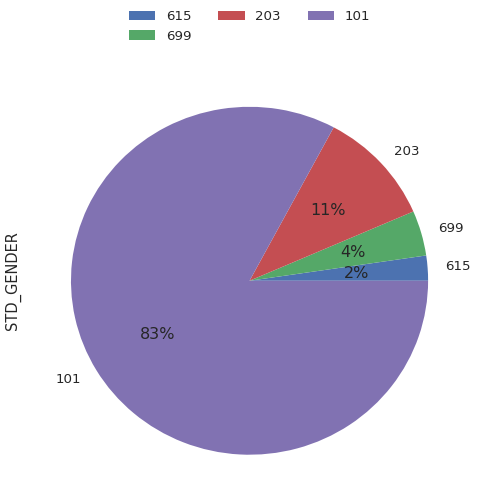

In [10]:
display(demographicDF)


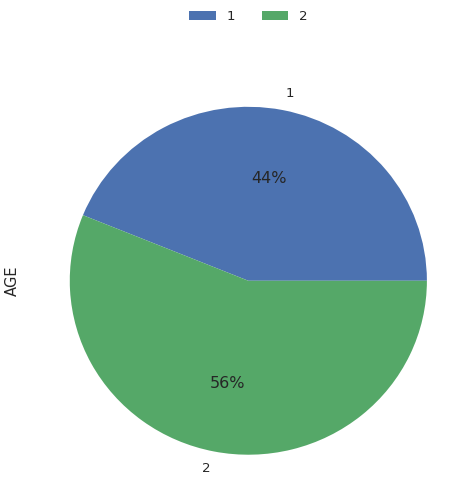

In [11]:
display(demographicDF)

In [12]:
len(cohorts.getPatientsWithDisease(1))

39635


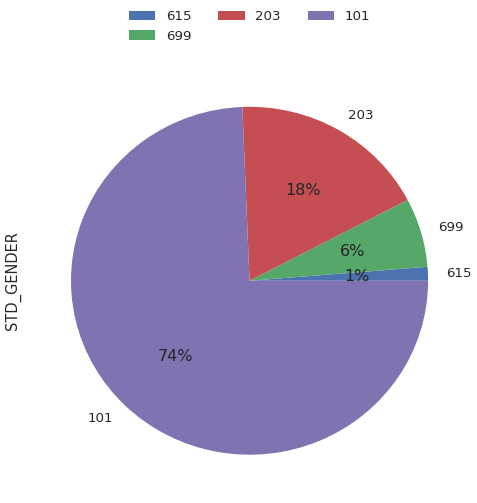

In [13]:
display(cohorts.getDemographics(2))

### Page 2: Classsification Model

In [14]:
cohorts.getFeatureMatrix()

array([[  1, 101,  94],
       [  1, 101,  74],
       [  2, 101,  81],
       ..., 
       [  2, 101,  78],
       [  1, 101, 106],
       [  2, 101,  65]])

In [15]:
cohorts.getFeatureMatrix(2)

array([[  2, 101,  74],
       [  2, 101,  63],
       [  2, 101, 107],
       [  2, 203,  58],
       [  1, 101, 104],
       [  2, 101,  77],
       [  2, 203,  80],
       [  2, 101,  92],
       [  1, 101,  40],
       [  1, 101,  78],
       [  1, 101,  66],
       [  2, 101,  85],
       [  2, 203,  81],
       [  1, 203,  81],
       [  2, 101,  78],
       [  1, 101,  81],
       [  1, 101,  91],
       [  1, 101,  85],
       [  1, 101,  87],
       [  2, 101,  82],
       [  2, 101,  81],
       [  1, 101,  48],
       [  1, 699,  50],
       [  2, 101,  97],
       [  2, 101,  79],
       [  1, 101,  74],
       [  1, 101,  85],
       [  1, 101,  81],
       [  1, 101,  74],
       [  1, 101,  89],
       [  1, 101,  60],
       [  1, 101,  87],
       [  2, 699,  88],
       [  2, 101,  83],
       [  1, 203,  92],
       [  2, 203,  93],
       [  1, 101,  85],
       [  2, 101,  77],
       [  1, 101,  76],
       [  2, 101,  89],
       [  2, 101,  84],
       [  2, 101

In [16]:
cohorts.getFeatureMatrix(2, ['AGE', 'STD_RACE'])

array([[ 74, 101],
       [ 63, 101],
       [107, 101],
       [ 58, 203],
       [104, 101],
       [ 77, 101],
       [ 80, 203],
       [ 92, 101],
       [ 40, 101],
       [ 78, 101],
       [ 66, 101],
       [ 85, 101],
       [ 81, 203],
       [ 81, 203],
       [ 78, 101],
       [ 81, 101],
       [ 91, 101],
       [ 85, 101],
       [ 87, 101],
       [ 82, 101],
       [ 81, 101],
       [ 48, 101],
       [ 50, 699],
       [ 97, 101],
       [ 79, 101],
       [ 74, 101],
       [ 85, 101],
       [ 81, 101],
       [ 74, 101],
       [ 89, 101],
       [ 60, 101],
       [ 87, 101],
       [ 88, 699],
       [ 83, 101],
       [ 92, 203],
       [ 93, 203],
       [ 85, 101],
       [ 77, 101],
       [ 76, 101],
       [ 89, 101],
       [ 84, 101],
       [ 78, 101],
       [ 88, 101],
       [ 53, 101],
       [ 86, 203],
       [ 83, 101],
       [ 79, 101],
       [ 65, 203],
       [ 42, 101],
       [ 91, 101],
       [ 78, 699],
       [ 88, 699],
       [ 52,